In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2
import tqdm
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import ImageGrid

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
fly = 241
func = 'func_0'
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

In [2]:
brain_file = os.path.join(load_directory, 'functional_channel_2_moco_zscore_highpass.h5')
with h5py.File(brain_file, 'r') as hf:
    brain = hf['data'][:]

func_0


In [3]:
brain_file = os.path.join(load_directory, 'imaging', 'functional_channel_1_mean.nii')
temporal_mean = np.asarray(nib.load(brain_file).get_fdata().squeeze(), dtype='float32')

In [4]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))
fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))

Trying to load timestamp data from hdf5 file.
Success.


In [5]:
resolution = 10 #desired resolution in ms
fps = 100
expt_len = int(fictrac_raw.shape[0]/fps*1000) 
camera_rate = 1/fps * 1000 # camera frame rate in ms
x_original = np.arange(0,expt_len,camera_rate)

timestep = np.diff(timestamps[:,0])[0] #is units of ms
num_tp = timestamps.shape[0]

num_x = brain.shape[0]
num_y = brain.shape[1]
num_z = brain.shape[2]

In [6]:
###############################
### BUILD X BEHAVIOR MATRIX ###
###############################

time_shifts = list(range(-5000,5000,20)) # in ms

beh_X_matrix = {}
for behavior,full_beh in zip(['Y', 'Z-', 'Z+'], ['dRotLabY', 'dRotLabZ', 'dRotLabZ']):

    # Smooth raw fictrac data
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[full_beh]),25,3)
    
    # Clip +/- turning
    if '+' in behavior:
        fictrac_smoothed = np.clip(fictrac_smoothed, a_min=0, a_max=None)
    if '-' in behavior:
        fictrac_smoothed = np.clip(fictrac_smoothed, a_min=None, a_max=0)*-1
                             
    # just in case
    fictrac_smoothed = np.nan_to_num(fictrac_smoothed)
                             
    # Create interp object with camera timepoints
    fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    
    # Interpolate across shifts
    behavior_shifts = []
    for z in range(num_z):
        _ = []
        for shift in time_shifts:
            fictrac_interp = np.nan_to_num(fictrac_interp_object(timestamps[:,z]+shift))
            _.append(fictrac_interp)
        behavior_shifts.append(np.asarray(_))
    beh_X_matrix[behavior] = np.asarray(behavior_shifts)

In [7]:
beh_X_matrix['Y'].shape

(7, 500, 6222)

In [8]:
brain.shape

(128, 86, 7, 6222)

In [9]:
# want to end up with 128,86,7,500
filters = {}
filters_smo = {}
for behavior in ['Y', 'Z-', 'Z+']:
    print(behavior)
    temp = []
    for z in range(num_z):
        for x in range(num_x):
            for y in range(num_y):
                temp.append(np.dot(beh_X_matrix[behavior][z], brain[x,y,z,:]))
    filters[behavior] = np.reshape(np.asarray(temp),(num_z,num_x,num_y,500))
    filters_smo[behavior] = scipy.signal.savgol_filter(filters[behavior],71,3,axis=-1)

Y
Z-
Z+


In [10]:
filters_smo['Y'].shape

(7, 128, 86, 500)

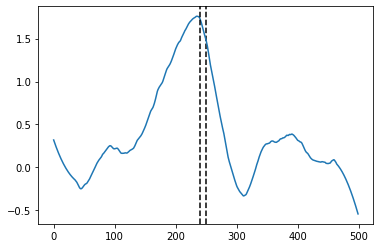

In [16]:
#plt.plot(filters['Y'][3,31,43,:])
plt.axvline(250,color='k',linestyle='--')

plt.plot(filters_smo['Y'][3,31,43,:])
#plt.plot(temp[:,3,31,43]*5)

plt.axvline(240,color='k',linestyle='--')


#plt.xlim(200,300)

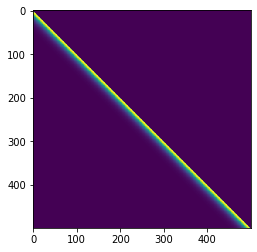

In [14]:
###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 50, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 450), 'constant')

toe = scipy.linalg.toeplitz(filter_padded,r=[0]*500)
plt.imshow(toe)

In [15]:
##################
### Deconvolve ###
##################

filters_deconv = {}
peak_times = {}
peak_values = {}
for behavior in ['Y', 'Z-', 'Z+']:
    print(behavior)

    all_signals = np.reshape(filters_smo[behavior],(-1,500))
    all_signals_flipped = all_signals[:,::-1]

    # deconvolve
    deconv = np.linalg.lstsq(toe, all_signals_flipped.T)[0]
    deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

    # Remove edge artifact
    deconv_smooth[:5,:] = deconv_smooth[5,:]
    deconv_smooth[-5:,:] = deconv_smooth[-5,:]

    # Flip back to being backwards in time
    deconv_smooth = deconv_smooth[::-1,:]
    filters_deconv[behavior] = np.reshape(deconv_smooth,(500,7,128,86))
    
    # get peak values and times
    peak_values[behavior] = np.max(filters_deconv[behavior],axis=0)
    peak_times[behavior] = np.argmax(filters_deconv[behavior],axis=0)

Y


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


Z-
Z+


In [17]:
start_c = 265 ###
end_c = 200 ######## most used
middle_c = 250 ###

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle_c-end_c))
colors2 = plt.cm.Reds(np.linspace(0, 1, start_c-middle_c))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

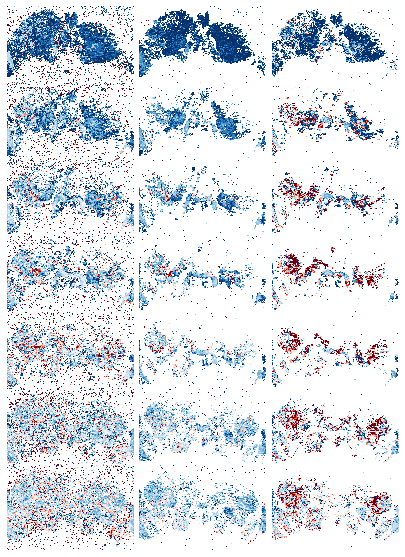

In [18]:
fig = plt.figure(figsize=(10,10))

thresholds = [.1,.3,.3]

for z in range(num_z):
    for j,behavior in enumerate(['Y', 'Z-', 'Z+']):
        plt.subplot(num_z,3,(z*3+j)+1)
        #plt.imshow(peak_times[behavior][z,:,:].T,cmap=mymap,vmin=end_c,vmax=start_c);

        to_plot = peak_times[behavior][z,:,:].T*(peak_values[behavior][z,:,:].T>thresholds[j])
        to_plot = to_plot.astype('float')
        to_plot[np.where(to_plot==0)] = np.nan
        plt.imshow(to_plot,cmap=mymap,vmin=end_c,vmax=start_c);
        plt.axis('off')

plt.subplots_adjust(hspace=-.1,wspace=-.55)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

# ALIGN

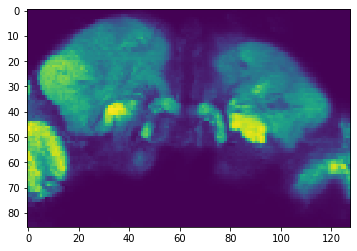

In [23]:
plt.imshow(temporal_mean[:,:,3].T)

In [20]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA[:,:,::-1])
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2,2,2),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

In [21]:
moving = ants.from_numpy(temporal_mean)
moving.set_spacing((3.07,3.07,5.0))

In [ ]:
7

In [24]:
moving

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (128, 86, 7)
	 Spacing    : (3.07, 3.07, 5.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [25]:
FDA_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [94]:
### width of subvol comes directly from subvol
# r="radius", o="original"
xr_o = int(np.ceil(moving.shape[0]/2))
yr_o = int(np.ceil(moving.shape[1]/2))
zr_o = int(np.ceil(moving.shape[2]/2))
print(xr_o,yr_o,zr_o)

64 43 4


In [35]:
zr

7

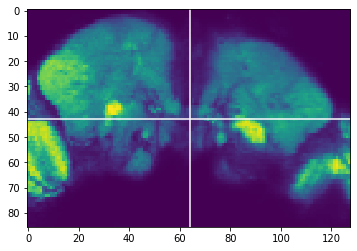

In [176]:
plt.imshow(moving[:,:,zr_o].T)
plt.axvline(xr_o,color='w')
plt.axhline(yr_o,color='w')

In [333]:
# this subvolume is 128 wide, with 3.07 um, so 392.96 um wide
# FDA is 314 wide, with 2 um, so 628 um wide

#subvol is 7*5=35um deep, so in 2um space should have about 17 slices

392.96

In [90]:
35/2

17.5

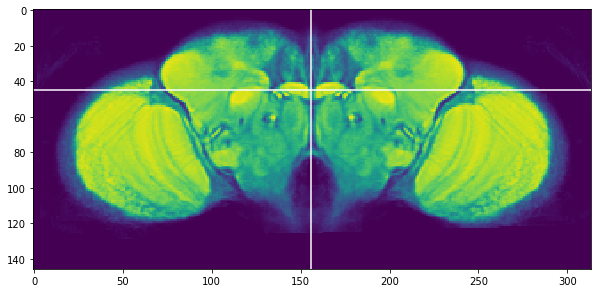

In [88]:
############################################################
### user must estimate the center of their subvol on FDA ###
############################################################

xc = 156
yc = 45
zc = 15

plt.figure(figsize=(10,10))
plt.imshow(FDA_lowres[:,:,zc].T)
plt.axvline(xc,color='w')
plt.axhline(yc,color='w')

In [40]:
zr_o*5/2

7.5

In [32]:
moving.spacing

(3.07, 3.07, 5.0)

In [95]:
new_box = []
for i,r in enumerate([xr_o,yr_o,zr_o]):
    new_box.append(int(r*moving.spacing[i]/FDA_lowres.spacing[i]))
xr = new_box[0]
yr = new_box[1]
zr = new_box[2]

In [96]:
xr,yr,zr

(98, 66, 10)

In [97]:
def newbox(c,r):
    return slice(*(np.clip(c-r,0,None),c+r))

In [140]:
### need to crop FDA down to the approximate subvol region
#FDA_lowres_cropped = FDA_lowres[xc-xr:xc+xr,yc-yr:yc+yr,zc-zr:zc+zr]
FDA_lowres_cropped = FDA_lowres[newbox(xc,xr),newbox(yc,yr),newbox(zc,zr)]
FDA_lowres_cropped = ants.from_numpy(FDA_lowres_cropped)
FDA_lowres_cropped.set_spacing((2,2,2))

In [81]:
FDA_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [100]:
FDA_lowres_cropped

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (196, 111, 20)
	 Spacing    : (0.76, 0.76, 0.76)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [113]:
zr,zr_o

(10, 4)

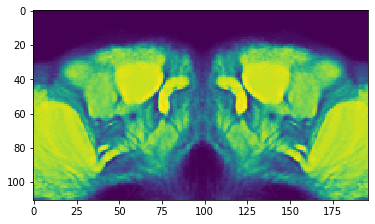

In [154]:
plt.imshow(FDA_lowres_cropped[:,:,5].T)

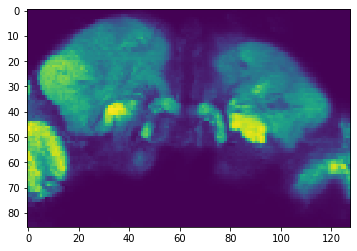

In [145]:
plt.imshow(moving[:,:,3].T)

In [149]:
out = ants.registration(fixed=FDA_lowres_cropped,moving=moving,type_of_transform='Affine',aff_metric='mattes')

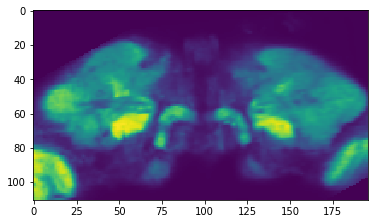

In [153]:
plt.imshow(out['warpedmovout'][:,:,5].T)

# try with luke mean


In [169]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
#luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [167]:
luke_mean_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 49)
	 Spacing    : (2.6076, 2.6154, 5.3125)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

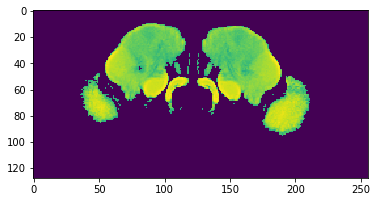

In [170]:
plt.imshow(luke_mean_lowres[:,:,10].T)

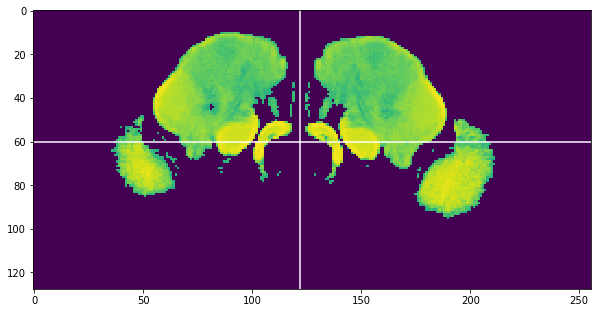

In [183]:
############################################################
### user must estimate the center of their subvol on FDA ###
############################################################

xc = 122
yc = 60
zc = 10

plt.figure(figsize=(10,10))
plt.imshow(luke_mean_lowres[:,:,zc].T)
plt.axvline(xc,color='w')
plt.axhline(yc,color='w')

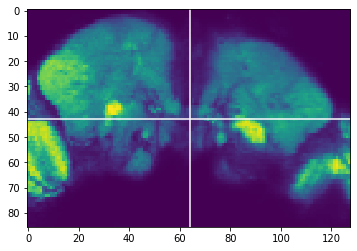

In [179]:
plt.imshow(moving[:,:,zr_o].T)
plt.axvline(xr_o,color='w')
plt.axhline(yr_o,color='w')

In [186]:
new_box = []
for i,r in enumerate([xr_o,yr_o,zr_o]):
    new_box.append(int(r*moving.spacing[i]/luke_mean_lowres.spacing[i]))
xr = new_box[0]
yr = new_box[1]
zr = new_box[2]

In [187]:
luke_mean_lowres_cropped = luke_mean_lowres[newbox(xc,xr),newbox(yc,yr),newbox(zc,zr)]
luke_mean_lowres_cropped = ants.from_numpy(luke_mean_lowres_cropped)
luke_mean_lowres_cropped.set_spacing(luke_mean_lowres.spacing)

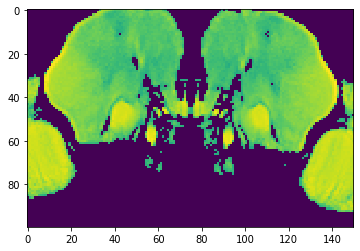

In [217]:
plt.imshow(luke_mean_lowres_cropped[:,:,5].T)

In [190]:
out = ants.registration(fixed=luke_mean_lowres_cropped,moving=moving,type_of_transform='Affine',aff_metric='mattes')

In [207]:
out

{'fwdtransforms': ['/tmp/tmpkfcnd3190GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpkfcnd3190GenericAffine.mat'],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 86, 7)
 	 Spacing    : (3.07, 3.07, 5.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedmovout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (150, 100, 6)
 	 Spacing    : (2.6076, 2.6154, 5.3125)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]}

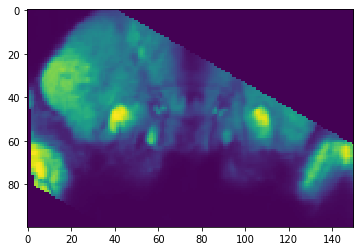

In [204]:
plt.imshow(out['warpedmovout'][:,:,5].T)

In [205]:
luke_mean_lowres_cropped

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (150, 100, 6)
	 Spacing    : (2.6076, 2.6154, 5.3125)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [206]:
fixed = np.zeros((150, 100, 10))
fixed = ants.from_numpy(fixed)
fixed.set_spacing(luke_mean_lowres_cropped.spacing)

In [208]:
out2 = ants.apply_transforms(fixed=fixed,moving=moving,transformlist=out['fwdtransforms'])

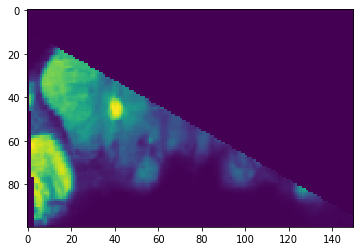

In [215]:
plt.imshow(out2[:,:,7].T)

In [ ]:
plt.imshow(luke_mean_lowres[:,:,zc].T)

# Alignment fresh space

In [ ]:
### need to make this alignment slightly more complicated.
# 1) Align to cropped lukemean (this is the correct "pitch"/"tilt")
# 2) apply transform but use the un-cropped fixed space
# 3) then warp to FDA

#### STEP 1) align to cropped lukemean

In [4]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
#luke_mean = luke_mean[:,:,::-1] #flipz #<-----------
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres = ants.resample_image(luke_mean,(2,2,2),use_voxels=False)

In [5]:
luke_mean_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (333, 166, 128)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

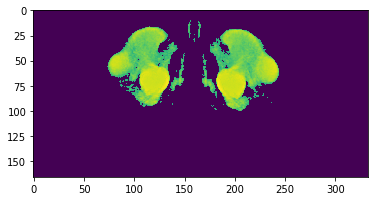

In [8]:
plt.imshow(luke_mean_lowres[:,:,20].T)

In [ ]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)


In [ ]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)
#fixed_lowres = ants.resample_image(fixed,(2.6,2.6,5),use_voxels=False)

out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

maps_voxel_res_ = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    moving = ants.from_numpy(all_colored_by_betas_full_[beh_idx][:,:,::-1])
    moving.set_spacing((2.6076, 2.6154, 5.3125)) ### matching this to the slightly off luke mean
    maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], interpolator='nearestNeighbor')
    maps_voxel_res_[beh_idx] = maps_voxel_res

In [10]:
### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed_jrc = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed_jrc = ants.from_numpy(fixed_jrc[:,:,::-1])
fixed_jrc.set_spacing(res_JRC2018)
fixed_jrc_lowres = ants.resample_image(fixed_jrc,(2,2,2),use_voxels=False)
fixed_jrc_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

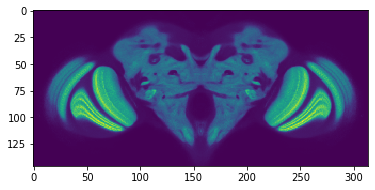

In [11]:
plt.imshow(fixed_jrc_lowres[:,:,20].T)

In [13]:
out = ants.registration(fixed_jrc_lowres, luke_mean_lowres, type_of_transform='Affine')

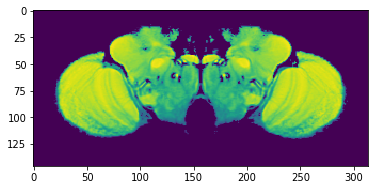

In [14]:
plt.imshow(out['warpedmovout'][:,:,20].T)

In [12]:
### Load FDA ###
FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
FDA = ants.from_numpy(FDA)

In [17]:
FDA.set_spacing((0.38,0.38,0.38))
FDA_lowres = ants.resample_image(FDA,(2,2,2),use_voxels=False)
FDA_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

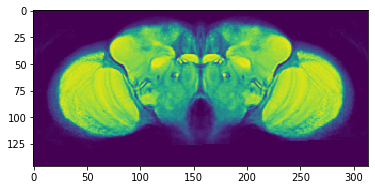

In [19]:
plt.imshow(FDA_lowres[:,:,91-20].T)

# fresh fresh fresh!!!

In [4]:
###################
### LOAD BRAINS ###
###################

### Load Luke Exp ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
luke_exp = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_exp = ants.from_numpy(luke_exp)
luke_exp.set_spacing((0.65,0.65,1))
luke_exp_lowres = ants.resample_image(luke_exp,(2,2,2),use_voxels=False)
print('Loaded Luke Exp')

### Load Luke Raw ###
in_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii"
luke_raw = np.asarray(nib.load(in_file).get_data(), dtype='float32')
luke_raw = ants.from_numpy(luke_raw)
luke_raw.set_spacing((.65,.65,1))
luke_raw_lowres = ants.resample_image(luke_raw,(2,2,2),use_voxels=False)
print('Loaded Luke Raw')

### Load FDA ###
FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
FDA = ants.from_numpy(FDA[...,::-1]) #FLIP Z
FDA.set_spacing((0.38,0.38,0.38))
FDA_lowres = ants.resample_image(FDA,(2,2,2),use_voxels=False)
print('Loaded FDA')

### Load JRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed_jrc = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed_jrc = ants.from_numpy(fixed_jrc[:,:,::-1])
fixed_jrc.set_spacing(res_JRC2018)
fixed_jrc_lowres = ants.resample_image(fixed_jrc,(2,2,2),use_voxels=False)
print('Loaded JRC2018')

Loaded Luke Exp
Loaded Luke Raw
Loaded FDA
Loaded JRC2018


In [5]:
### this is how we get from luke space to FDA space
exp2jrc = ants.registration(fixed_jrc_lowres, luke_exp_lowres, type_of_transform='Affine')

In [6]:
moving = ants.from_numpy(temporal_mean)
moving.set_spacing((3.07,3.07,5.0))

In [7]:
### width of subvol comes directly from subvol
# r="radius", o="original"
xr_o = int(np.ceil(moving.shape[0]/2))
yr_o = int(np.ceil(moving.shape[1]/2))
zr_o = int(np.ceil(moving.shape[2]/2))
print(xr_o,yr_o,zr_o)

64 43 4


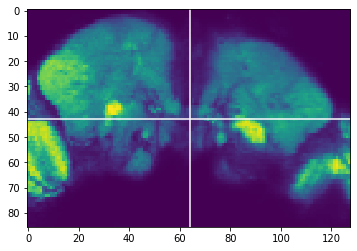

In [8]:
plt.imshow(moving[:,:,zr_o].T)
plt.axvline(xr_o,color='w')
plt.axhline(yr_o,color='w')

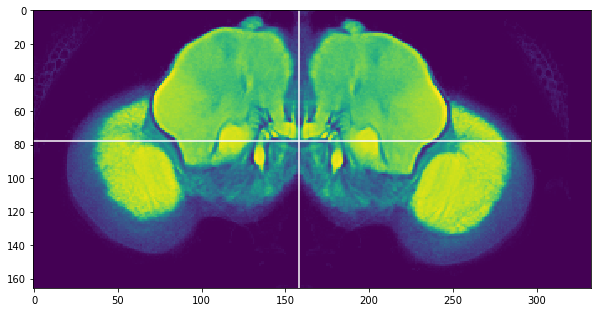

In [9]:
### estimate center of moving on luke_raw

xc = 158
yc = 78
zc = 31

plt.figure(figsize=(10,10))
plt.imshow(luke_raw_lowres[:,:,zc].T)
plt.axvline(xc,color='w')
plt.axhline(yc,color='w')

In [10]:
def newbox(c,r):
    return slice(*(np.clip(c-r,0,None),c+r))

new_box = []
for i,r in enumerate([xr_o,yr_o,zr_o]):
    new_box.append(int(r*moving.spacing[i]/luke_raw_lowres.spacing[i]))
xr = new_box[0]
yr = new_box[1]
zr = new_box[2]

luke_raw_lowres_cropped = luke_raw_lowres[newbox(xc,xr),newbox(yc,yr),newbox(zc,zr)]
luke_raw_lowres_cropped = ants.from_numpy(luke_raw_lowres_cropped)
luke_raw_lowres_cropped.set_spacing(luke_raw_lowres.spacing)

In [23]:
newbox(zc,zr)

slice(21, 41, None)

In [11]:
luke_raw_lowres_cropped.shape

(196, 132, 20)

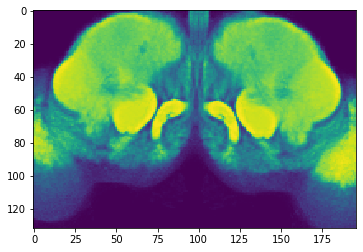

In [12]:
### this should look like moving
plt.imshow(luke_raw_lowres_cropped[:,:,zr_o].T)

In [13]:
### align subvol ("moving") to this cropped luke_raw
# NOTE: THIS WARP STEP SOMETIMES LOOKS GOOD, SOMEIMES BAD, SO CHECK
subvol_to_lukeraw = ants.registration(luke_raw_lowres_cropped, moving, type_of_transform='Affine')

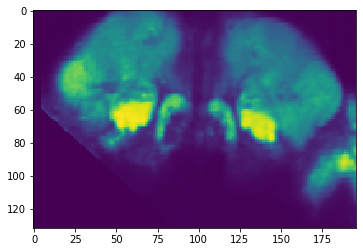

In [14]:
### this should look like luke_raw_lowres_cropped
plt.imshow(subvol_to_lukeraw['warpedmovout'][:,:,zr_o].T)

In [15]:
subvol_to_lukeraw['warpedmovout']

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (196, 132, 20)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [15]:
### make 2um moving and pad
moving_2um = ants.resample_image(moving,(2,2,2),use_voxels=False)
moving_2um

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (196, 132, 18)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [18]:
xr,yr,zr

(98, 66, 10)

In [ ]:
#first z pad top
pad = np.zeros((moving.shape[0],moving.shape[1],num_z_pad))



In [16]:
luke_raw_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (333, 166, 128)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [16]:
num_z_pad=10
pad = np.zeros((moving.shape[0],moving.shape[1],num_z_pad))
moving_padded = np.concatenate((pad, moving.numpy(), pad),axis=-1)
moving_padded = ants.from_numpy(moving_padded)
moving_padded.set_spacing(moving.spacing)

In [17]:
moving_padded

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (128, 86, 27)
	 Spacing    : (3.07, 3.07, 5.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [18]:
luke_raw_lowres

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (333, 166, 128)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [19]:
### this warp will copy subvol_to_lukeraw, but will avoid clipping the subvol

fixed = np.zeros(luke_raw_lowres.shape)
fixed = ants.from_numpy(fixed)
fixed.set_spacing((2,2,2))
subvol_to_luke_full = ants.apply_transforms(fixed=fixed,
                                            moving=moving_padded,
                                            transformlist=subvol_to_lukeraw['fwdtransforms'])

In [20]:
### need to roll this into the correct position
subvol_to_luke_full

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (333, 166, 128)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

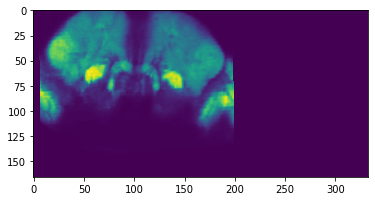

In [23]:
plt.imshow(subvol_to_luke_full[:,:,30].T)

In [28]:
int((333-196)/2)

68

In [29]:
test = np.roll(subvol_to_luke_full.numpy(),int((333-196)/2),axis=0)
test = np.roll(test,int((166-132)/2),axis=1)
#test = np.roll(test,int((166-132)/2),axis=2)

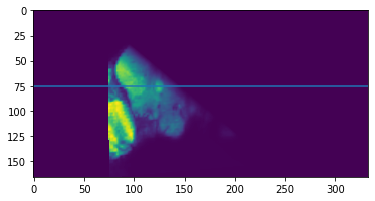

In [43]:
plt.imshow(test[:,:,40].T)
plt.axhline(75)

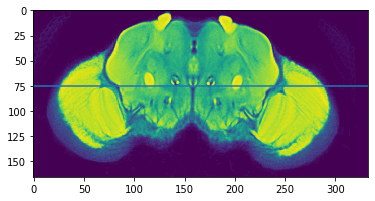

In [44]:
plt.imshow(luke_raw_lowres[:,:,40].T)
plt.axhline(75)

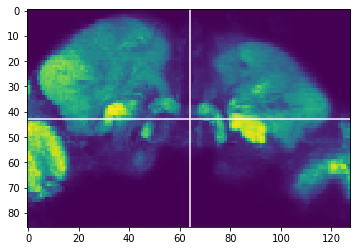

In [99]:
plt.imshow(moving[:,:,-4].T)
plt.axvline(xr_o,color='w')
plt.axhline(yr_o,color='w')

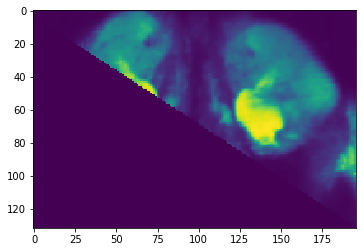

In [95]:
### this should look like luke_raw_lowres_cropped
plt.imshow(subvol_to_lukeraw['warpedmovout'][:,:,0].T)

In [ ]:
out = ants.affine_initializer(fixed_image=luke_raw_lowres,
                              moving_image=moving,
                              use_principal_axis=True,
                              search_factor=10,
                              radian_fraction=1,
                              local_search_iterations=10)

In [ ]:
temp = ants.apply_transforms(fixed=luke_raw_lowres,
                                            moving=moving,
                                            transformlist=[out])

In [ ]:
plt.imshow(np.max(temp.numpy(),axis=-1).T)